# Mental Health in the Tech Industry
![Superhero Data Analyst](mental_health.png)

<p style="text-indent: 40px;">
    The tech industry is a crucial part of our economy, with businesses increasingly relying on technology as digitization becomes the norm. However, for employees, this can mean long hours and the challenge of solving complex problems, which can eventually lead to mental health issues in this rapidly growing field.
</p>
<p style="text-indent: 40px;">
  I've been hired by Google to analyze mental health surveys and identify the risk factors contributing to these issues. My goal is to provide insights into where employers should invest more to support their workforce and promote better mental health.
</p>
<br>

## The dataset.
Google has provided me with a dataset of mental health survey data for the years 2014 and 2016-2019.<br><br>
They uploaded it on Kaggle for public use:<br>
https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry
<br><br>
## Data analysis

1. Loading the data
2. Data cleaning
3. Basic metrics
4. Main analysis
5. Summary

First we handle the imports.

In [58]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import black
import numpy as np

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


And set matplotlib, pandas and seaborn display parameters.

In [2]:
sns.set_theme(style="darkgrid")

custom_palette = sns.color_palette("viridis")

sns.set_palette(custom_palette)

plt.rcParams.update(
    {
        "axes.facecolor": "#303845",
        "axes.edgecolor": "#303845",
        "axes.labelcolor": "white",
        "figure.facecolor": "#303845",
        "grid.color": "gray",
        "text.color": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "axes.titlecolor": "white",
        "figure.titlesize": 18,
        "axes.titlesize": 16,
    }
)

pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

# 1. Loading the data
It's time to load and perform an initial inspection of the dataset.

In [3]:
conn = sqlite3.connect("mental_health.sqlite")

cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('Answer',), ('Question',), ('Survey',)]

So as you can see we have three tables:
1. Answer
2. Question
3. Survey
<br>

Let's look at them individually.

In [4]:
answer_query = """
                SELECT *
                FROM Answer
                LIMIT 5;
               """

df = pd.read_sql_query(answer_query, conn)
df

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


This is the main table with the answers to the surveys.
<br><br>
It contains the answer text, year of the survey and user/question ids.
<br><br>
The Primary Key is **UserID** while the Foreign Keys are **QuestionID** and **SurveyID** which we will be using for joining with the other two tables.
<br><br>
Let's also look at the number of rows.

In [5]:
count_query = """
                SELECT COUNT(*)
                FROM Answer
               """

df = pd.read_sql_query(count_query, conn)
df

,COUNT(*)
0,236898


Almost 237k rows. However we notice a strange thing that there are 105 questions and 236898 is not divisible by five, which means that the dataset does not have all the answers for every user. Therefore we should group the answers based on UserID and see what the value counts are.

In [6]:
value_counts_query = """
                SELECT UserID, COUNT(*)
                FROM Answer
                GROUP BY UserID
                ORDER BY COUNT(*) DESC
               """
df = pd.read_sql_query(value_counts_query, conn)
df.head(5)

,UserID,COUNT(*)
0,4218,76
1,4217,76
2,4216,76
3,4215,76
4,4214,76


In [7]:
df.tail(5)

,UserID,COUNT(*)
4213,5,26
4214,4,26
4215,3,26
4216,2,26
4217,1,26


The number of answers per UserID seems to range from 26 to 76

In [8]:
question_query = """
                SELECT *
                FROM Question
                LIMIT 5;
               """

df = pd.read_sql_query(question_query, conn)
df

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5


Here we have all the questions used in the survey. 
<br>
Let's look how many we have.

In [9]:
count_query = """
                SELECT COUNT(*)
                FROM Question
                LIMIT 5;
               """

df = pd.read_sql_query(count_query, conn)
df

,COUNT(*)
0,105


The dataset contains answers to 105 questions.

In [10]:
survey_query = """
                SELECT *
                FROM Survey
                LIMIT 5;
               """

df = pd.read_sql_query(survey_query, conn)
df

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


The ID itself already contains the year so this data is redundant.<br>

# 2. Data cleaning
Let's look at the data types and also null values and duplicates if they exist.

In [11]:
query = """
PRAGMA table_info(Answer);
"""

schema_df = pd.read_sql_query(query, conn)
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,AnswerText,VARCHAR(10000),0,None,0
1,1,SurveyID,INTEGER,0,None,0
2,2,UserID,INTEGER,0,None,0
3,3,QuestionID,INTEGER,0,None,0


The data types are appropriate.<br>
No nulls in the **Answer** table.

In [12]:
query = """
PRAGMA table_info(Question);
"""

schema_df = pd.read_sql_query(query, conn)
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,questiontext,VARCHAR(1000),0,None,0
1,1,questionid,INTEGER,0,None,0


Same with the **Question** table.

In [13]:
duplicates_query = """
                    SELECT AnswerText, 
                           SurveyID, 
                           UserID, 
                           QuestionID, 
                           COUNT(*) as count
                    FROM Answer
                    GROUP BY AnswerText, SurveyID, UserID, QuestionID
                    HAVING COUNT(*) > 1;
                    """

duplicates_df = pd.read_sql_query(duplicates_query, conn)
duplicates_df

,AnswerText,SurveyID,UserID,QuestionID,count


No duplicate rows in the **Answer** table.

In [14]:
duplicates_query = """
                    SELECT questiontext, 
                           questionid,
                           COUNT(*) as count
                    FROM Question
                    GROUP BY questiontext, questionid
                    HAVING COUNT(*) > 1;
                    """

duplicates_df = pd.read_sql_query(duplicates_query, conn)
duplicates_df

,questiontext,questionid,count


No duplicates for the **Question** table.

# 3. Basic metrics.

It's time to get an initial understanding of the dataset.<br><br>
We will achieve this using summary statistics.<br><br>
Then we will look at the distributions, counts and frequencies.<br><br>
First let's look at the number of users and answers collected for each year the survey was done.

In [15]:
yearly_users_query = """
                      SELECT SurveyID AS Year, COUNT(DISTINCT UserID) AS Survey_Users
                      FROM Answer
                      GROUP BY Year
                      ORDER BY Year
                     """
yearly_users_df = pd.read_sql_query(yearly_users_query, conn)
yearly_users_df

,Year,Survey_Users
0,2014,1260
1,2016,1433
2,2017,756
3,2018,417
4,2019,352


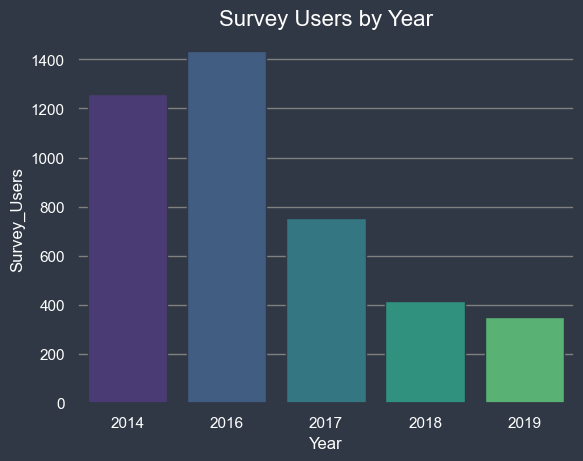

In [16]:
sns.barplot(data=yearly_users_df, x="Year", y="Survey_Users", edgecolor="#303845")
plt.title("Survey Users by Year")
plt.show()

As you can see the year with most users was 2016. <br>
2019 has the least amount of users who participated in the survey.<br><br>
Now let's check the number of answers for each year.

In [17]:
yearly_answers_query = """
                      SELECT SurveyID AS Year, COUNT(AnswerText) AS Number_of_answers
                      FROM Answer
                      GROUP BY Year
                      ORDER BY Year
                     """
yearly_answers_df = pd.read_sql_query(yearly_answers_query, conn)
yearly_answers_df

,Year,Number_of_answers
0,2014,32760
1,2016,88238
2,2017,57456
3,2018,31692
4,2019,26752


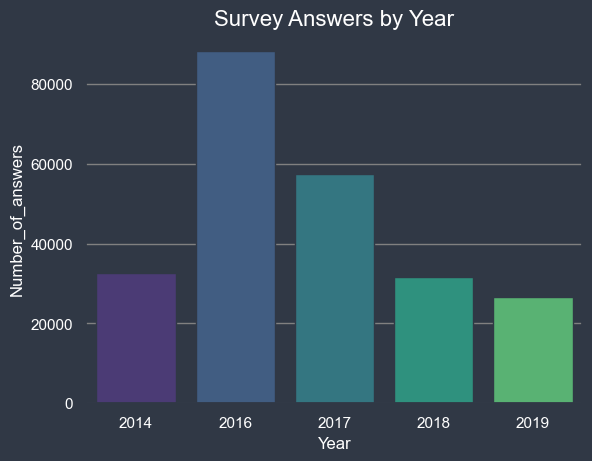

In [18]:
sns.barplot(
    data=yearly_answers_df, x="Year", y="Number_of_answers", edgecolor="#303845"
)
plt.title("Survey Answers by Year")

plt.show()

The barplots are similar by proportion except for the year 2014 where we have a big number of participants and yet a small number of answers in comparison.<br><br>
We saw earlier how the number of answers ranges from 26 to 76 for users. Let's take a look at the most and least frequently answered questions.

In [19]:
low_answers_query = """
                     SELECT o.questiontext,
                            COUNT(a.questionid) AS count
                     FROM Answer AS a
                     JOIN Question AS o
                     ON a.QuestionID = o.QuestionID
                     GROUP BY o.questiontext
                     ORDER BY COUNT(a.questionid)
                     LIMIT 5;
                    """
low_answers_query = pd.read_sql_query(low_answers_query, conn)
low_answers_query

,questiontext,count
0,Any additional notes or comments,1260
1,Do you know the options for mental health care your employer provides?,1260
2,Do you think that discussing a mental health issue with your employer would have negative consequences?,1260
3,Do you work remotely (outside of an office) at least 50% of the time?,1260
4,Does your employer provide resources to learn more about mental health issues and how to seek help?,1260


These are some of the answers that have the least amount of entries.<br>

In [20]:
top_answers_query = """
                      SELECT o.questiontext,
                             COUNT(a.questionid) AS count
                      FROM Answer AS a
                      JOIN Question AS o
                      ON a.QuestionID = o.QuestionID
                      GROUP BY o.questiontext
                      ORDER BY COUNT(a.questionid) DESC
                      LIMIT 5;
                     """
top_answers_query = pd.read_sql_query(top_answers_query, conn)
top_answers_query

,questiontext,count
0,Would you bring up a mental health issue with a potential employer in an interview?,4218
1,What is your gender?,4218
2,What is your age?,4218
3,What country do you live in?,4218
4,Is your employer primarily a tech company/organization?,4218


It could be that there is a different number of questions for each year as perhaps the survey changed over time, that's what it seems like based on the high number of duplicate counts.
<br><br>
Let's check the value counts for each year to make sure.

In [21]:
query_2014 = """
                      SELECT a.surveyid,
                             COUNT(DISTINCT o.questionid)
                      FROM Answer AS a
                      JOIN Question AS o
                      ON a.QuestionID = o.QuestionID
                      GROUP BY a.surveyid
                      ORDER BY o.questionid DESC
                     """
query_2014 = pd.read_sql_query(query_2014, conn)
query_2014

,SurveyID,COUNT(DISTINCT o.questionid)
0,2019,76
1,2018,76
2,2017,76
3,2016,60
4,2014,26


Aha! So even though there's 105 different questions in total, there's only 26 questions in the survey data from 2014 and 76 questions for the years 2017-2019, that explains a lot. We will have to keep in mind that some questions might only exist in certain years.
<br><br>
It also explains why there's so little answers compared to the number of users who have taken the survey in 2014 - there were only 26 questions at the time.
<br><br>
### Age groups.
Analyzing further we would like to check the age distributions for each year.

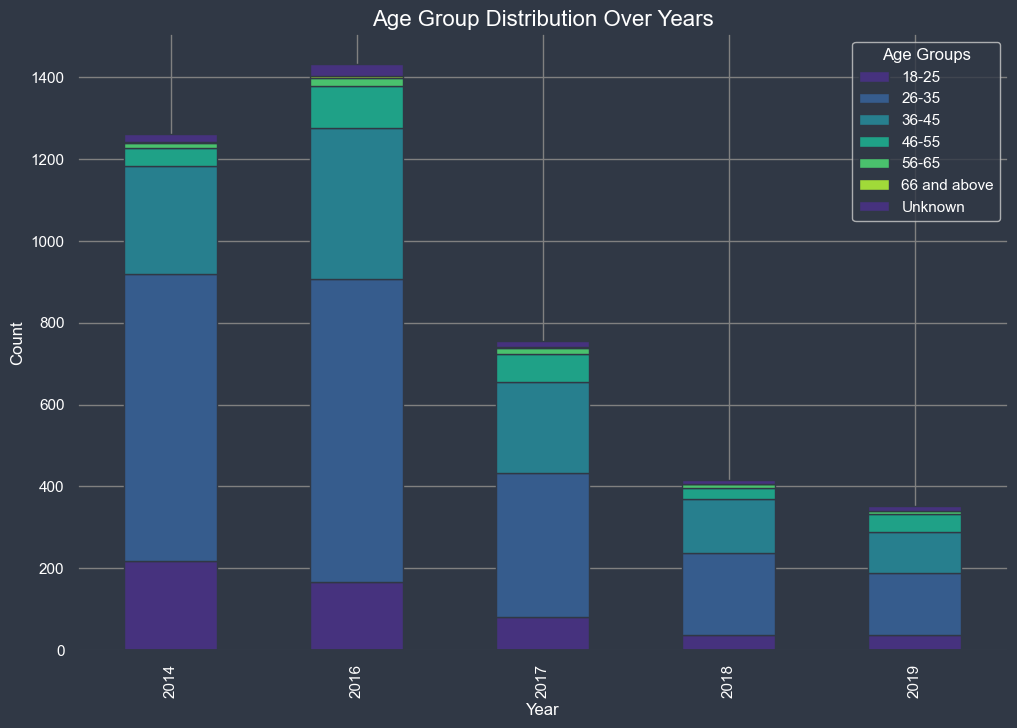

In [22]:
age_query = """
            SELECT 
                SurveyID AS Year, 
                CASE 
                    WHEN CAST(answertext AS INTEGER) BETWEEN 18 AND 25 THEN '18-25'
                    WHEN CAST(answertext AS INTEGER) BETWEEN 26 AND 35 THEN '26-35'
                    WHEN CAST(answertext AS INTEGER) BETWEEN 36 AND 44 THEN '36-45'
                    WHEN CAST(answertext AS INTEGER) BETWEEN 46 AND 55 THEN '46-55'
                    WHEN CAST(answertext AS INTEGER) BETWEEN 56 AND 65 THEN '56-65'
                    WHEN CAST(answertext AS INTEGER) >= 66 THEN '66 and above'
                    ELSE 'Unknown'
                END AS AgeGroup,
                COUNT(*) as Count
            FROM Answer
            WHERE questionid = 1
            GROUP BY Year, AgeGroup
            ORDER BY Year, AgeGroup
            """

grouped_data = pd.read_sql_query(age_query, conn)

pivot_data = grouped_data.pivot(index="Year", columns="AgeGroup", values="Count")

pivot_data.plot(kind="bar", stacked=True, figsize=(12, 8), edgecolor="#303845")
plt.title("Age Group Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Age Groups", loc="upper right")
plt.show()

So we can see that most of the data comes from people aged 26-35, the second most frequent age group is 36-45 and then we have 18-25 and 46-55 which are of similar quantity.
<br><br>
### Gender groups.
Let's do the same but with gender.

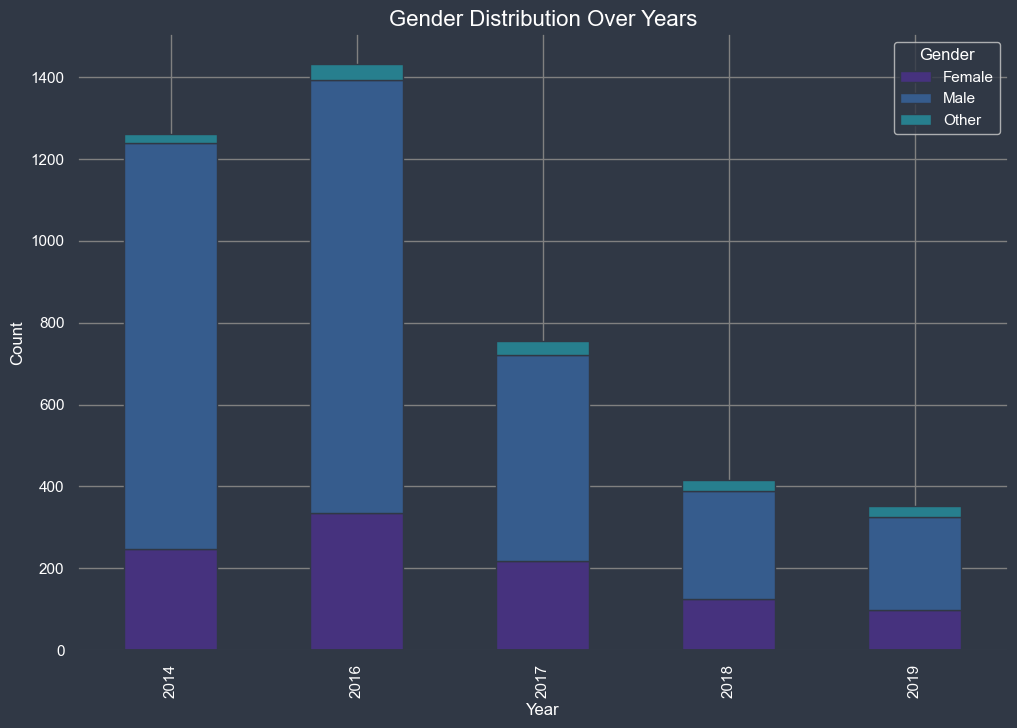

In [23]:
gender_query = """
                SELECT 
                    SurveyID AS Year, 
                    CASE WHEN answertext IN ('female', 'Female') THEN 'Female'
                         WHEN answertext IN ('male', 'Male') THEN 'Male' 
                         ELSE 'Other' END AS Gender,
                    COUNT(*) as Count
                FROM Answer
                WHERE questionid = 2
                GROUP BY Year, Gender
                ORDER BY Year, Gender
                """

grouped_data = pd.read_sql_query(gender_query, conn)

pivot_data = grouped_data.pivot(index="Year", columns="Gender", values="Count")

pivot_data.plot(kind="bar", stacked=True, figsize=(12, 8), edgecolor="#303845")
plt.title("Gender Distribution Over Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Gender", loc="upper right")
plt.show()

Most of the data comes from males with females representing only about 25-30% of the dataset. A small fraction of people identify themselves with something else and unfortunately we will not be focusing our analysis on them.
<br><br>
### Primary employer.
Our analysis is focused on the tech industry and therefore it is important to filter our dataset for tech workers. Let's see what proportion of the survey results come from this sector.

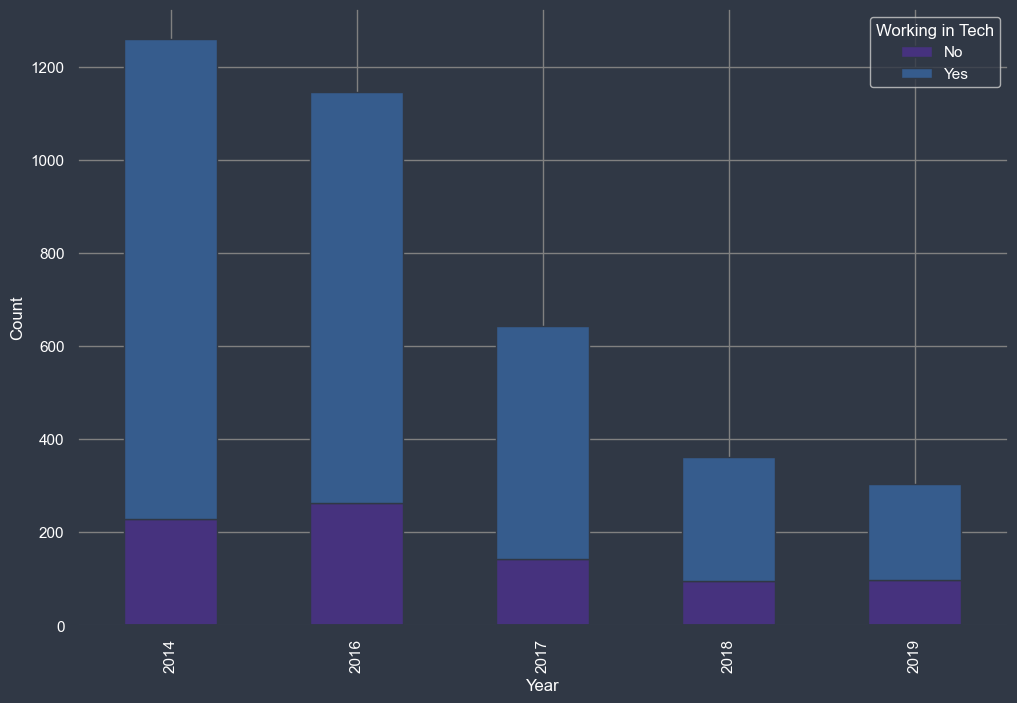

In [24]:
employer_query = """
                SELECT 
                    SurveyID AS Year, 
                    CASE WHEN answertext = '0' THEN 'No'
                         WHEN answertext = '1' THEN 'Yes'
                         END AS tech_worker,
                    COUNT(*) as Count
                FROM Answer
                WHERE questionid = 9 AND answertext <> '-1'
                GROUP BY Year, tech_worker
                ORDER BY Year, tech_worker
                """

employer_df = pd.read_sql_query(employer_query, conn)

pivot_data = employer_df.pivot(index="Year", columns="tech_worker", values="Count")

pivot_data.plot(kind="bar", stacked=True, figsize=(12, 8), edgecolor="#303845")
plt.legend(title="Working in Tech", loc="upper right")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

The bigger part of the dataset comes from tech workers on which we are focusing our analysis but 20% of the datapoints come from non-tech workers.<br>

# 4. Main analysis.
<br>
In this part I will be trying to find answers on what are the key areas influencing the mental health of tech workers and what are the assosiated risk factors that could be used by businesses to have a better understanding of their employees needs.
<br><br>
First we will need to identify which of the workers have said mental issues and what is the proportion of these cases. These can be found in the following questions:<br><br>
	1. Have you had a mental health disorder in the past?  - QuestionID	32<br>
    2. Do you currently have a mental health disorder?	- QuestionID    33<br>
    3. Have you ever been diagnosed with a mental health disorder?  - QuestionID	  34

In [25]:
mental_health_query = """
                      SELECT AnswerText, QuestionID, COUNT(*)
                      FROM Answer
                      WHERE QuestionID IN(32, 33, 34)
                      GROUP BY QuestionID, AnswerText
                     """
mental_health_df = pd.read_sql_query(mental_health_query, conn)
mental_health_df

,AnswerText,QuestionID,COUNT(*)
0,-1,32,15
1,Don't Know,32,109
2,Maybe,32,246
3,No,32,896
4,Possibly,32,275
5,Yes,32,1417
6,Don't Know,33,124
7,Maybe,33,327
8,No,33,969
9,Possibly,33,301


Before continuing our analysis we will have to classify these as numerical values so we can perform other statistical tests.<br><br>
I don't know what -1 means so I will exclude these values from my analysis. "Don't know", "Maybe" and "Possibly" indicate varying degrees of uncertainty so I will try to use these as ordinal variables in this sequence:<br><br>

No < Don't know < Maybe < Possibly < Yes
<br><br>
I will use this encoding to compute correlations:<br>
No: 0<br>
Don't Know: 0.25<br>
Maybe: 0.5<br>
Possibly: 0.75<br>
Yes: 1<br><br>
I would also like to group these by year and whether or not the people are working in tech because I want to see if there is a meaningful difference of mental health between tech and non-tech workers. I also want to see if there is a temporal trend.

In [26]:
mental_health_query2 = """
                        SELECT a.UserID,
                               CASE WHEN a.AnswerText = 'No' THEN 0
                                    WHEN a.AnswerText = "Don't Know" THEN 0.25
                                    WHEN a.AnswerText = 'Maybe' THEN 0.5
                                    WHEN a.AnswerText = 'Possibly' THEN 0.75
                                    WHEN a.AnswerText = 'Yes' THEN 1
                                    END AS mental_health,
                                    a.SurveyID as Year,
                                    sub.AnswerText AS Tech
                        FROM Answer AS a
                        JOIN (
                            SELECT UserID,
                                   AnswerText
                            FROM Answer
                            WHERE QuestionID = 9 AND AnswerText <> '-1'
                        ) sub
                        ON a.UserID = sub.UserID
                        WHERE a.QuestionID IN (32, 33, 34) 
                            AND a.AnswerText <> '-1'
                        """

mental_health_df2 = pd.read_sql_query(mental_health_query2, conn)
mental_health_df2.head(5)

,UserID,mental_health,Year,Tech
0,1261,0.0,2016,1
1,1261,1.0,2016,1
2,1261,1.0,2016,1
3,1262,1.0,2016,1
4,1262,1.0,2016,1


Now we have values for mental health, the assosiated year and whether or not the person who answered is working in tech. First let's look at the distributions of mental health rating for tech and non-tech individuals. But since this contains values for three questions for each UserID I will take the averages and plot those.

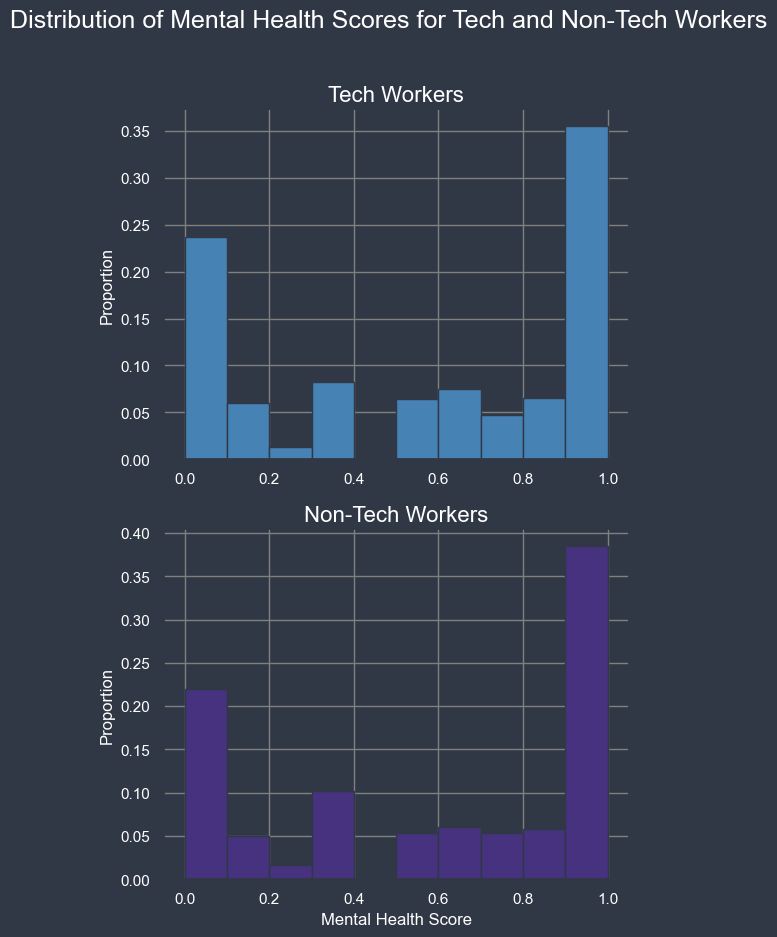

In [27]:
tech_workers = mental_health_df2[mental_health_df2["Tech"] == "1"]
grouped_tech = (
    tech_workers.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

non_tech_workers = mental_health_df2[mental_health_df2["Tech"] == "0"]
grouped_non_tech = (
    non_tech_workers.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

sns.histplot(
    data=grouped_tech,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[0],
    color="steelblue",
    edgecolor="#303845",
    alpha=1,
)
axes[0].set_title("Tech Workers")
axes[0].set_xlabel("")
axes[0].set_ylabel("Proportion")

sns.histplot(
    data=grouped_non_tech,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[1],
    edgecolor="#303845",
    alpha=1,
)
axes[1].set_title("Non-Tech Workers")
axes[1].set_xlabel("Mental Health Score")
axes[1].set_ylabel("Proportion")

plt.suptitle("Distribution of Mental Health Scores for Tech and Non-Tech Workers")
plt.show()

In [28]:
mental_health_grouped = mental_health_df2.groupby("UserID").agg(
    {"mental_health": "mean", "Tech": "first"}
)
mental_health_grouped.corr()

,mental_health,Tech
mental_health,1.000000,-0.022224
Tech,-0.022224,1.000000


So apparently within this dataset there seems to be almost no difference between the mental health status for tech and non-tech workers. There is no correlation between the variables.<br><br>
Regardless we see that there are more datapoints on the right side of the plot which means that the bigger part of survey takers have had mental health issues diagnosed in the past or currently are struggling with them so that's why it's important for us to uncover the assosiated risk factors. <br><br>
### Gender and mental health.
But before that let's also look at the different distributions based on gender.

In [29]:
mental_health_query3 = """
                        SELECT a.UserID,
                               CASE WHEN a.AnswerText = 'No' THEN 0
                                    WHEN a.AnswerText = "Don't Know" THEN 0.25
                                    WHEN a.AnswerText = 'Maybe' THEN 0.5
                                    WHEN a.AnswerText = 'Possibly' THEN 0.75
                                    WHEN a.AnswerText = 'Yes' THEN 1
                                    END AS mental_health,
                                    a.SurveyID as Year,
                                    sub.Gender
                        FROM Answer AS a
                        JOIN (
                            SELECT UserID,
                                   CASE WHEN answertext IN ('female', 'Female') THEN 'Female'
                                        WHEN answertext IN ('male', 'Male') THEN 'Male' 
                                        ELSE 'Other' END AS Gender
                            FROM Answer
                            WHERE questionid = 2
                        ) sub
                        ON a.UserID = sub.UserID
                        WHERE a.QuestionID IN (32, 33, 34) 
                            AND a.AnswerText <> '-1'
                        """


mental_health_df3 = pd.read_sql_query(mental_health_query3, conn)
mental_health_df3.head(5)

,UserID,mental_health,Year,Gender
0,1261,0.0,2016,Male
1,1261,1.0,2016,Male
2,1261,1.0,2016,Male
3,1262,1.0,2016,Male
4,1262,1.0,2016,Male


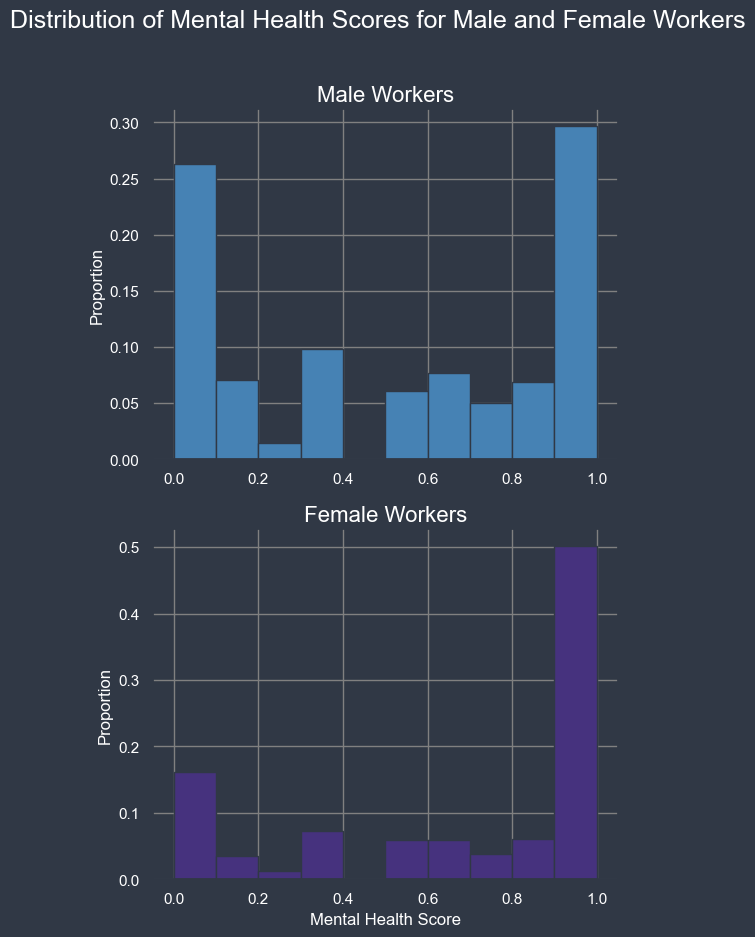

In [30]:
male_workers = mental_health_df3[mental_health_df3["Gender"] == "Male"]
grouped_male = (
    male_workers.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

female_workers = mental_health_df3[mental_health_df3["Gender"] == "Female"]
grouped_female = (
    female_workers.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

sns.histplot(
    data=grouped_male,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[0],
    color="steelblue",
    edgecolor="#303845",
    alpha=1,
)
axes[0].set_title("Male Workers")
axes[0].set_xlabel("")
axes[0].set_ylabel("Proportion")

sns.histplot(
    data=grouped_female,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[1],
    edgecolor="#303845",
    alpha=1,
)
axes[1].set_title("Female Workers")
axes[1].set_xlabel("Mental Health Score")
axes[1].set_ylabel("Proportion")

plt.suptitle("Distribution of Mental Health Scores for Male and Female Workers")
plt.show()

In [31]:
mental_health_df3["Gender"] = mental_health_df3["Gender"].map({"Male": 1, "Female": 0})
mental_health_grouped = mental_health_df3.groupby("UserID").agg(
    {"mental_health": "mean", "Gender": "first"}
)

mental_health_grouped.head(5)

,mental_health,Gender
UserID,,
1261,0.666667,1.0
1262,1.000000,1.0
1263,0.166667,1.0
1264,1.000000,1.0
1265,1.000000,0.0


In [32]:
mental_health_grouped.corr()

,mental_health,Gender
mental_health,1.000000,-0.178928
Gender,-0.178928,1.000000


Hmm, it seems that females are struggling a lot more with mental health with 50% having been diagnosed or currently having a mental health issue and only 16% who have no signs.<br><br>
Whereas males with current or previous mental health issues amount to only about 30% and 27% reporting no issues. It could be that males are more reluctant to disclose their problems as well. <br><br>
But this is mostly visible on the edges around 0 and 1, around the middle there is a similar situation for both genders and the correlation of the two variables is insignificant.
### Job role in IT and mental health.
The previous comparison for tech workers was about people working in tech, there is another question with the ID 13 about whether or not the person's role is in IT. This could be a better indicator so let's see what we find.

In [33]:
mental_health_query4 = """
                        SELECT a.UserID,
                               CASE WHEN a.AnswerText = 'No' THEN 0
                                    WHEN a.AnswerText = "Don't Know" THEN 0.25
                                    WHEN a.AnswerText = 'Maybe' THEN 0.5
                                    WHEN a.AnswerText = 'Possibly' THEN 0.75
                                    WHEN a.AnswerText = 'Yes' THEN 1
                                    END AS mental_health,
                                    a.SurveyID as Year,
                                    sub.AnswerText AS Tech
                        FROM Answer AS a
                        JOIN (
                            SELECT UserID,
                                   AnswerText
                            FROM Answer
                            WHERE QuestionID = 13 AND AnswerText <> '-1'
                        ) sub
                        ON a.UserID = sub.UserID
                        WHERE a.QuestionID IN (32, 33, 34) 
                            AND a.AnswerText <> '-1'
                        """

mental_health_df4 = pd.read_sql_query(mental_health_query4, conn)
mental_health_df4.head(5)

,UserID,mental_health,Year,Tech
0,1265,1.0,2016,1
1,1265,1.0,2016,1
2,1265,1.0,2016,1
3,1269,1.0,2016,1
4,1269,1.0,2016,1


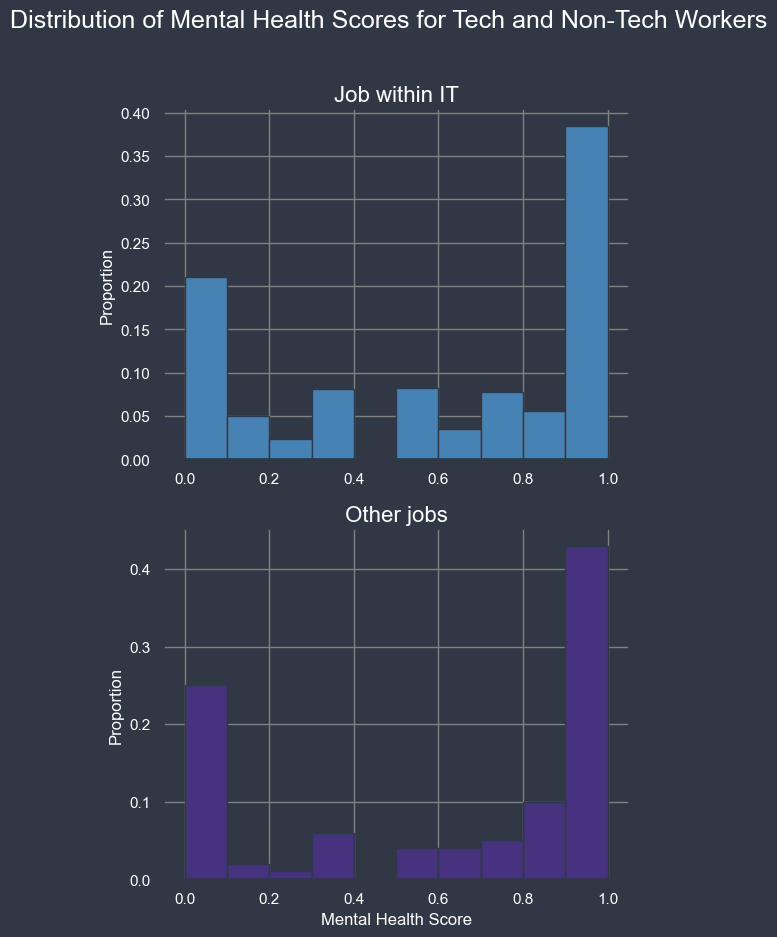

In [34]:
job_with_it = mental_health_df4[mental_health_df4["Tech"] == "1"]
grouped_tech = (
    job_with_it.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

other_job = mental_health_df4[mental_health_df4["Tech"] == "0"]
grouped_non_tech = (
    other_job.groupby("UserID").agg({"mental_health": "mean"}).reset_index()
)

fig, axes = plt.subplots(2, 1, figsize=(6, 10))

sns.histplot(
    data=grouped_tech,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[0],
    color="steelblue",
    edgecolor="#303845",
    alpha=1,
)
axes[0].set_title("Job within IT")
axes[0].set_xlabel("")
axes[0].set_ylabel("Proportion")

sns.histplot(
    data=grouped_non_tech,
    x="mental_health",
    bins=10,
    stat="proportion",
    ax=axes[1],
    edgecolor="#303845",
    alpha=1,
)
axes[1].set_title("Other jobs")
axes[1].set_xlabel("Mental Health Score")
axes[1].set_ylabel("Proportion")

plt.suptitle("Distribution of Mental Health Scores for Tech and Non-Tech Workers")
plt.show()

In [53]:
mental_health_df4["Tech"] = mental_health_df4["Tech"].astype(int)
mental_health_df4[["mental_health", "Tech"]].corr()

,mental_health,Tech
mental_health,1.000000,-0.015694
Tech,-0.015694,1.000000


Again we see something similar as before, maybe even slightly more healthy answers from people who's job is within the IT field, but no significant difference.<br><br>
### Working in IT and Gender vs. mental health.
Let's combine the two genders and people working in IT to create some boxplots and see if there is any meaningful difference. First we will have to combine the two queries.

In [35]:
mental_health_query5 = """
                        SELECT a.UserID,
                               CASE WHEN a.AnswerText = 'No' THEN 0
                                    WHEN a.AnswerText = "Don't Know" THEN 0.25
                                    WHEN a.AnswerText = 'Maybe' THEN 0.5
                                    WHEN a.AnswerText = 'Possibly' THEN 0.75
                                    WHEN a.AnswerText = 'Yes' THEN 1
                                    END AS mental_health,
                                    a.SurveyID as Year,
                                    sub.AnswerText AS Tech,
                                    sub2.Gender
                        FROM Answer AS a
                        JOIN (
                            SELECT UserID,
                                   AnswerText
                            FROM Answer
                            WHERE QuestionID = 13 AND AnswerText <> '-1'
                        ) sub
                        ON a.UserID = sub.UserID
                        JOIN (
                            SELECT UserID,
                                   CASE WHEN answertext IN ('female', 'Female') THEN 'Female'
                                        WHEN answertext IN ('male', 'Male') THEN 'Male' 
                                        END AS Gender
                            FROM Answer
                            WHERE questionid = 2 AND answertext IN ('female', 'Female', 'male', 'Male')
                        ) sub2
                        ON a.UserID = sub2.UserID
                        WHERE a.QuestionID IN (32, 33, 34) 
                            AND a.AnswerText <> '-1'
                        """

mental_health_df5 = pd.read_sql_query(mental_health_query5, conn)
mental_health_df5.head(5)

,UserID,mental_health,Year,Tech,Gender
0,1265,1.0,2016,1,Female
1,1265,1.0,2016,1,Female
2,1265,1.0,2016,1,Female
3,1269,1.0,2016,1,Female
4,1269,1.0,2016,1,Female


In [36]:
mental_health_df5["Tech"] = mental_health_df5["Tech"].map(
    {"1": "Job in IT", "0": "Other jobs"}
)
mental_health_df5["Group"] = (
    mental_health_df5["Tech"] + " & " + mental_health_df5["Gender"]
)

mental_health_df5.head(5)

,UserID,mental_health,Year,Tech,Gender,Group
0,1265,1.0,2016,Job in IT,Female,Job in IT & Female
1,1265,1.0,2016,Job in IT,Female,Job in IT & Female
2,1265,1.0,2016,Job in IT,Female,Job in IT & Female
3,1269,1.0,2016,Job in IT,Female,Job in IT & Female
4,1269,1.0,2016,Job in IT,Female,Job in IT & Female


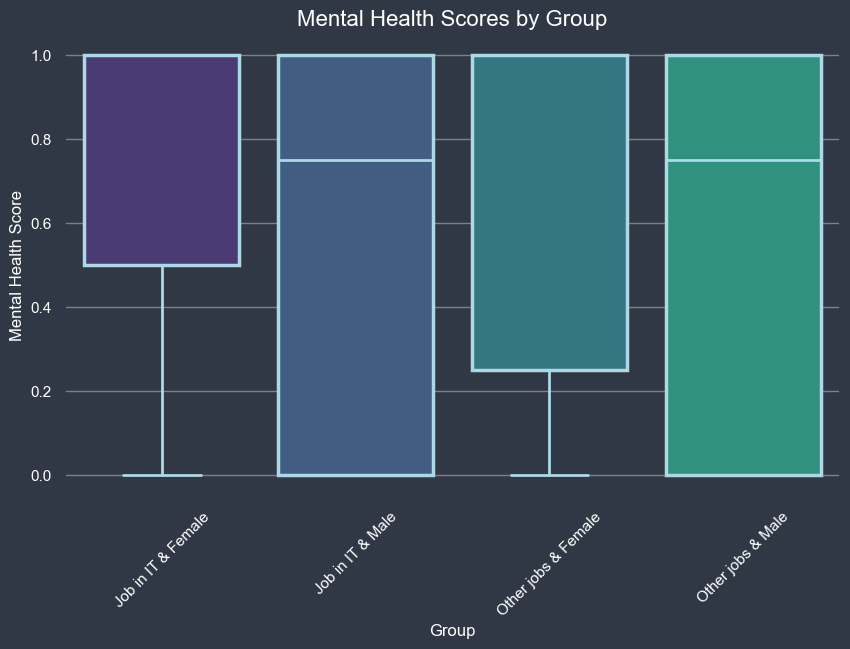

In [37]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    x="Group",
    y="mental_health",
    data=mental_health_df5,
    linewidth=2.5,
    boxprops={"edgecolor": "lightblue"},
    whiskerprops={"color": "lightblue", "linewidth": 2},
    capprops={"color": "lightblue", "linewidth": 2},
    medianprops={"color": "lightblue", "linewidth": 2},
)
ax.set_title("Mental Health Scores by Group")
ax.set_xlabel("Group")
ax.set_ylabel("Mental Health Score")
plt.xticks(rotation=45)

plt.show()

So the trend seems to be that females struggle with mental health more but females who also work in IT tend to struggle even more.<br><br> Here are the average mental health scores for each group with 1 meaning that the person has had issues in the past and has them currently while 0 means that they are completely fine.

In [38]:
mental_health_averages = mental_health_df5.groupby("Group").agg(
    {"mental_health": "mean"}
)
mental_health_averages

,mental_health
Group,
Job in IT & Female,0.740679
Job in IT & Male,0.591973
Other jobs & Female,0.721154
Other jobs & Male,0.558989


The average mental health score is higher (worse) for females by about 0.15 - 0.18 points with females in IT having 0.02 worse score than ones working in other fields.<br><br>
### Mental health in the USA compared to the rest of the world.

In [39]:
country_query = """
                 SELECT COUNT(*)
                 FROM Answer
                 WHERE QuestionID = 3
                """

country_df = pd.read_sql_query(country_query, conn)
country_df

,COUNT(*)
0,4218


There's only 4218 entries for country out of the 250~ thousand but we can still take a look how the United States compare to the rest of the world.

In [62]:
usa_vs_world = """
                        SELECT CASE WHEN a.AnswerText = 'No' THEN 0
                                    WHEN a.AnswerText = "Don't Know" THEN 0.25
                                    WHEN a.AnswerText = 'Maybe' THEN 0.5
                                    WHEN a.AnswerText = 'Possibly' THEN 0.75
                                    WHEN a.AnswerText = 'Yes' THEN 1
                                    END AS mental_health,
                                    sub.AnswerText AS Country
                        FROM Answer AS a
                        JOIN (
                            SELECT UserID,
                                   AnswerText
                            FROM Answer
                            WHERE QuestionID = 3 AND AnswerText IS NOT NULL
                        ) sub
                        ON a.UserID = sub.UserID
                        WHERE a.QuestionID IN (32, 33, 34) 
                            AND a.AnswerText <> '-1'
                        """

usa_vs_world_df = pd.read_sql_query(usa_vs_world, conn)
usa_vs_world_df.head(5)

,mental_health,Country
0,0.0,United Kingdom
1,1.0,United Kingdom
2,1.0,United Kingdom
3,1.0,United States of America
4,1.0,United States of America


In [63]:
filtered_df = usa_vs_world_df[usa_vs_world_df["Country"] != "-1"]

country_averages = filtered_df.groupby("Country").agg({"mental_health": "mean"})

usa_average = country_averages.loc["United States of America"]

rest_of_world_average = country_averages[
    country_averages.index != "United States of America"
].mean()

print("Average Mental Health Score in the USA:", usa_average.values[0])
print(
    "Average Mental Health Score in the Rest of the World:",
    rest_of_world_average.values[0],
)

Average Mental Health Score in the USA: 0.6626112759643917
Average Mental Health Score in the Rest of the World: 0.39120669845535894


The mental health situation in the USA seems to be much more dire in the USA compared to the rest of the world. That's why it's imperative that employers in the USA take action.<br><br>
## Ethnicity and mental health.
We need to investigate if race affects mental health, but it's also important to consider where people are living. For example, we might find different results for individuals who are living in a country that is different from where their race is predominantly from.<br><br>
For the purposes of this we will only be looking at the different races that are residents of USA.

In [42]:
race_query = """
              SELECT AnswerText,
                     COUNT(*)
              FROM Answer
              WHERE QuestionID = 89
              GROUP BY AnswerText
              ORDER BY COUNT(*) DESC
"""

race_df = pd.read_sql_query(race_query, conn)
race_df.head(10)

,AnswerText,COUNT(*)
0,White,873
1,-1,537
2,More than one of the above,35
3,Asian,31
4,I prefer not to answer,29
5,Black or African American,15
6,White Hispanic,1
7,Hispanic,1
8,European American,1
9,Caucasian,1


Unfortunately there isn't enough data to perform such an analysis. So let's move on to the next topic.<br><br>
### Remote work and mental health.
Let's see how remote worker's mental health compares to office workers and people who work remotely 50% of the time.

In [43]:
remote_query = """
                SELECT AnswerText,
                       COUNT(*)
                FROM Answer
                WHERE QuestionID = 104
                GROUP BY AnswerText
                ORDER BY COUNT(*) DESC
               """

remote_df = pd.read_sql_query(remote_query, conn)
remote_df.head(10)

,AnswerText,COUNT(*)
0,Maybe,487
1,No,438
2,-1,287
3,Yes,221


Hmm, I'm not sure how someone could answer 'Maybe' to such a direct question. We will be using the rows with 'Yes' and 'No.<br><br>
There is another question for workers who work remotely 50% of the time.

In [44]:
remote_50_query = """
                   SELECT AnswerText,
                          COUNT(*)
                   FROM Answer
                   WHERE QuestionID = 79
                   GROUP BY AnswerText
                   ORDER BY COUNT(*) DESC
                  """

remote_50_df = pd.read_sql_query(remote_50_query, conn)
remote_50_df.head(10)

,AnswerText,COUNT(*)
0,-1,1345
1,0,119
2,1,61


We will take the 61 values of '1' and add those to our analysis.<br><br>
Let's combine all of the information for users who answered about remote work and their mental health.

In [45]:
remote_mental_health_query = """
                              SELECT a.UserID,
                              CASE WHEN a.AnswerText = 'No' THEN 0
                                   WHEN a.AnswerText = "Don't Know" THEN 0.25
                                   WHEN a.AnswerText = 'Maybe' THEN 0.5
                                   WHEN a.AnswerText = 'Possibly' THEN 0.75
                                   WHEN a.AnswerText = 'Yes' THEN 1
                                   END AS mental_health,
                                   sub.AnswerText
                              FROM Answer AS a
                              JOIN (
                                    SELECT UserID,
                                           AnswerText
                                    FROM Answer
                                    WHERE QuestionID = 104 AND AnswerText IN ('Yes', 'No')
                                   ) sub
                              ON a.UserID = sub.UserID
                              WHERE a.QuestionID IN (32, 33, 34) AND 
                                    a.AnswerText <> '-1'
                              """

remote_mental_health_df = pd.read_sql_query(remote_mental_health_query, conn)
remote_mental_health_df.shape

(1977, 3)

In [46]:
remote_mental_health_df.head(5)

,UserID,mental_health,AnswerText
0,1261,0.0,No
1,1261,1.0,No
2,1261,1.0,No
3,1262,1.0,No
4,1262,1.0,No


In [47]:
remote_mental_health_df1 = remote_mental_health_df[["UserID", "mental_health"]]
remote_mental_health_df1 = remote_mental_health_df1.groupby("UserID").agg(
    {"mental_health": "mean"}
)
remote_mental_health_df2 = remote_mental_health_df.groupby("UserID").agg(
    {"AnswerText": "first"}
)

remote_mental_health_df1.reset_index(inplace=True)

remote_mental_df_full = remote_mental_health_df1.merge(
    remote_mental_health_df2, on="UserID"
)
remote_mental_df_full = remote_mental_df_full.set_index("UserID")
remote_mental_df_full.head(10)

,mental_health,AnswerText
UserID,,
1261,0.666667,No
1262,1.000000,No
1265,1.000000,Yes
1266,0.333333,Yes
1267,0.000000,No
1268,1.000000,No
1269,1.000000,Yes
1271,1.000000,No
1272,1.000000,Yes


In [48]:
remote_50_query = """
                   SELECT a.UserID,
                          CASE WHEN a.AnswerText = 'No' THEN 0
                                   WHEN a.AnswerText = "Don't Know" THEN 0.25
                                   WHEN a.AnswerText = 'Maybe' THEN 0.5
                                   WHEN a.AnswerText = 'Possibly' THEN 0.75
                                   WHEN a.AnswerText = 'Yes' THEN 1
                                   END AS mental_health,
                          sub.AnswerText
                   FROM Answer AS a
                   JOIN (
                         SELECT UserID,
                                AnswerText
                                FROM Answer
                                WHERE QuestionID = 79 AND AnswerText = '1'
                        ) sub
                   ON a.UserID = sub.UserID
                   WHERE mental_health IS NOT NULL
                  """

remote_50_df = pd.read_sql_query(remote_50_query, conn)
remote_50_df = remote_50_df.groupby("UserID").agg({"mental_health": "mean"})
remote_50_df["AnswerText"] = "50%"
remote_50_df.reset_index()
remote_50_df.head(10)

,mental_health,AnswerText
UserID,,
2696,0.666667,50%
2703,0.208333,50%
2729,0.365385,50%
2740,0.571429,50%
2746,0.500000,50%
2786,0.791667,50%
2815,0.812500,50%
2828,0.400000,50%
2831,0.785714,50%


In [49]:
remote_work_df = pd.concat([remote_mental_df_full, remote_50_df])
remote_work_df.head(10)

,mental_health,AnswerText
UserID,,
1261,0.666667,No
1262,1.000000,No
1265,1.000000,Yes
1266,0.333333,Yes
1267,0.000000,No
1268,1.000000,No
1269,1.000000,Yes
1271,1.000000,No
1272,1.000000,Yes


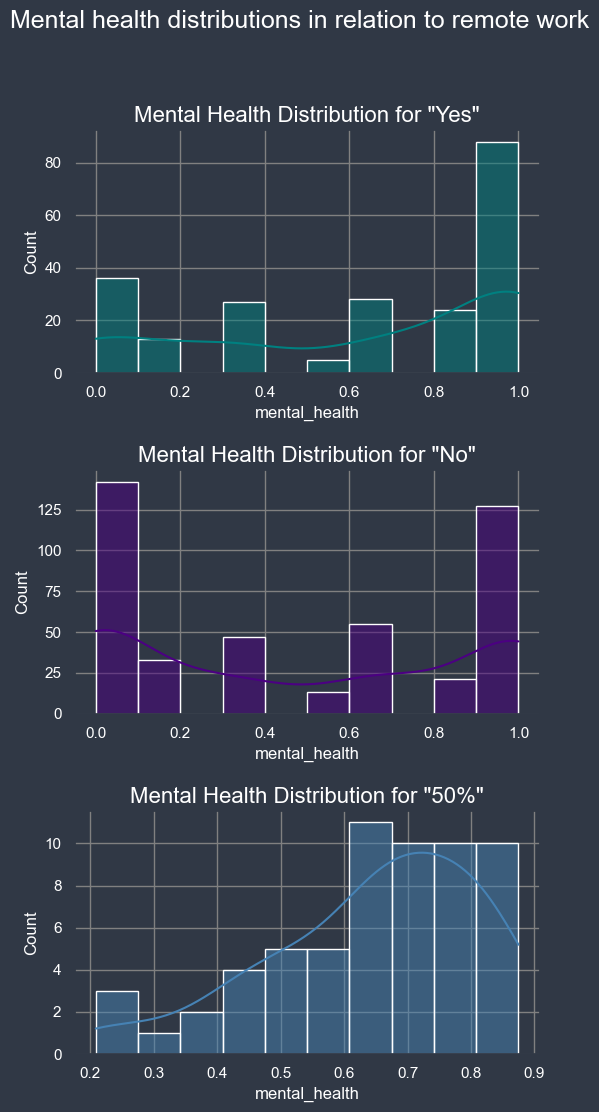

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

sns.histplot(
    data=remote_work_df[remote_work_df["AnswerText"] == "Yes"],
    x="mental_health",
    bins=10,
    ax=axes[0],
    color="teal",
    kde=True,
)
axes[0].set_title('Mental Health Distribution for "Yes"')

sns.histplot(
    data=remote_work_df[remote_work_df["AnswerText"] == "No"],
    x="mental_health",
    bins=10,
    ax=axes[1],
    color="indigo",
    kde=True,
)
axes[1].set_title('Mental Health Distribution for "No"')


sns.histplot(
    data=remote_work_df[remote_work_df["AnswerText"] == "50%"],
    x="mental_health",
    bins=10,
    ax=axes[2],
    color="steelblue",
    kde=True,
)
axes[2].set_title('Mental Health Distribution for "50%"')
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Mental health distributions in relation to remote work")
plt.show()

So from this data we can see that people who do not engage in remote work have slightly more values on the left side indicating better mental health and people working remotely 50% of the time exhibit poor scores, however there is a low amount of entries for these people so it would require more data.

# 5. Summary.

  In general there doesn't seem to be a strong relationship between tech and non-tech workers' remote health. If anything tech workers seem to exhibit just slightly better mental health with the exception being female workers in tech who are struggling more with these issues.
  <br><br>
  We need more data to understand how race and remote work influences mental health, but not working remotely seems to be in favor of mental health slightly over full-on remote work.
  <br><br>
  The workers in USA exhibit much more mental health concerns than the rest of the world.
  <br><br>
In the future we need to investigate this dataset more deeply as it has a ton of information from all sorts of questions. We could use a keyword analysis for some questions, do sentiment analysis and apply machine learning algorithms to better understand which people are at risk from which factors in the workplace.